In [1]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import pandas as pd
from unidecode import unidecode
import random, sys, io, re

/Users/michael/miniconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
songs = pd.read_csv('data/eminem-songs.csv')

In [3]:
def get_tokenized_lines(df):
    words = []
    
    for index, row in df['lyrics'].iteritems():
        row = str(row).lower()
        for line in row.split('|-|'):
            new_words = re.findall(r"\b[a-z']+\b", unidecode(line))
            words = words + new_words
            
    return words

In [4]:
all_lyric_lines = get_tokenized_lines(songs)

In [5]:
SEQ_LENGTH = 50 + 1
sequences = []

for i in range(SEQ_LENGTH, len(all_lyric_lines)):
    seq = all_lyric_lines[i - SEQ_LENGTH: i]
    sequences.append(seq)

print("Total Sequences: %d" % len(sequences))

Total Sequences: 377669


In [6]:
def save_doc(lines, filename):
    data = []
    for line in lines:
        data.append(" ".join(line))
        
    file = open(filename, 'w')
    file.write('\n'.join(data))
    file.close()

In [7]:
out_filename = "sequences.txt"
save_doc(sequences, out_filename)

In [8]:
vocab = set(all_lyric_lines)

word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for w, i in word_to_index.items()}
word_indices = [word_to_index[word] for word in vocab]
vocab_size = len(vocab)

print("vocabulary size: {}".format(vocab_size))

vocabulary size: 17495


In [9]:
def get_tokenized_lines(lines, seq_len):
    tokenized = np.zeros((len(lines), seq_len))
    
    for r, line in enumerate(lines):
        for c, word in enumerate(line):
            tokenized[r, c] = word_to_index[word]
            
    return tokenized

In [10]:
tokenized_seq = get_tokenized_lines(sequences, SEQ_LENGTH)

In [11]:
tokenized_seq[:, -1].shape

(377669,)

In [12]:
from keras.utils import to_categorical

X, y = tokenized_seq[:, :-1], tokenized_seq[:, -1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = len(X[0])

In [13]:
print("X_shape", X.shape)
print("y_shape", y.shape)

X_shape (377669, 50)
y_shape (377669, 17495)


In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, batch_size=128, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            874750    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 17495)             1766995   
Total params: 2,792,645
Trainable params: 2,792,645
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
377669/377669 [==============================] - 1686s 4ms/step - loss: 6.6358 - acc: 0.0409
Epoch 2/50
377669/37766

In [15]:
history.history['loss']

[6.635801353823869,
 6.196471450321056,
 5.985404256616327,
 5.794297040699274,
 5.636348066262054,
 5.495194495491133,
 5.365041641392477,
 5.246202683206313,
 5.135976611425109,
 5.033620675393083,
 4.940721758634721,
 4.8534282149747465,
 4.772793715482376,
 4.696389320866871,
 4.625212612327951,
 4.5576104618990545,
 4.493135081520334,
 4.433798131732176,
 4.376111340149863,
 4.322651716737397,
 4.267590020414747,
 4.2194214504550285,
 4.170011889897325,
 4.123761921258943,
 4.078591098672879,
 4.037202214991048,
 3.9961755059099233,
 3.954676456271928,
 3.917319390838222,
 3.8779295952268984,
 3.8431745030067006,
 3.8086116858718464,
 3.7746753046804886,
 3.742124948902355,
 3.711234480120419,
 3.680089154471024,
 3.651590141654338,
 3.623540153292416,
 3.5948442476502267,
 3.5703467443689205,
 3.541198598717311,
 3.518026604217989,
 3.4939481144359936,
 3.473044967624474,
 3.4472151802127096,
 3.4282025389923096,
 3.407088859222254,
 3.3859702372682334,
 3.36351086447487,
 3.3468

In [16]:
import matplotlib.pyplot as plt

/Users/michael/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


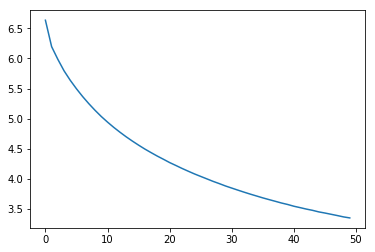

In [17]:
plt.plot(history.history['loss'])

In [18]:
model.save('model/eminem-model.h5')

In [19]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [20]:
in_filename = "sequences.txt"
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = SEQ_LENGTH - 1

In [22]:
from random import randint

seed_text = lines[randint(0, len(lines))]
print(seed_text + '\n')

it was a toy but know im a bit more older i see what it is its like a fucking pair on conjoint simese twins twinnnns one day my mother said to me why dont you ever play outside i used to crawl under my pool and hide i used to



In [23]:
def texts_to_sequences(texts, word_to_index):
    indices = np.zeros((1, len(texts)), dtype=int)
    
    for i, text in enumerate(texts):
        indices[:, i] = word_to_index[text]
        
    return indices

In [52]:
def my_pad_sequences(seq, maxlen):
    start = seq.shape[1] - maxlen
    
    return seq[:, start: start + maxlen]

In [89]:
def generate_seq(model, word_to_index, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    
    for _ in range(n_words):
        encoded = texts_to_sequences(in_text.split(), word_to_index)
        encoded = my_pad_sequences(encoded, maxlen=seq_length)
        
        yhat = model.predict_classes(encoded, verbose=0)
        out_word = ''
        
        for word, index in word_to_index.items():
            if index == yhat:
                out_word = word
                break
                
        in_text += ' ' + out_word
        result.append(out_word)
        
    return ' '.join(result)

In [79]:
generated0 = generate_seq(model, word_to_index, seq_length, seed_text, 50)
print(generated0)
print(len(generated0.split()))

get the back to say the back pounder when you get your ass like a gold nugget what they know about it i can't be a little bit i got places to stop crack it'll make your best side of us just a little person so i don't wanna get
50


In [87]:
encoded = texts_to_sequences(generated0.split(), word_to_index)
new_encoded = my_pad_sequences(encoded, seq_length)
yhat = model.predict_classes(new_encoded, verbose=0)
print(index_to_word[yhat[0]])

stampeded


In [90]:
generate_seq(model, word_to_index, seq_length, generated0, 50)

"stampeded and lose mama else to do i did is to begin it and what you shitted on a little stressed away from this shit is none of my body collapse chicka who mighty vodka you don't give a fuck about fun and the fuck i had a little slide"